# LOADING DATASET

In [ ]:
from datasets import load_dataset

ds = load_dataset("lucadiliello/newsqa")

In [ ]:
import pandas as pd
import numpy as np
display(ds)

DatasetDict({
    train: Dataset({
        features: ['context', 'question', 'answers', 'key', 'labels'],
        num_rows: 74160
    })
    validation: Dataset({
        features: ['context', 'question', 'answers', 'key', 'labels'],
        num_rows: 4212
    })
})

In [ ]:
train_data = ds["train"]
df = train_data.to_pandas()
print(df.head())
print(df.info())


                                             context  \
0  NEW DELHI, India (CNN) -- A high court in nort...   
1  NEW DELHI, India (CNN) -- A high court in nort...   
2  NEW DELHI, India (CNN) -- A high court in nort...   
3  NEW DELHI, India (CNN) -- A high court in nort...   
4  NEW DELHI, India (CNN) -- A high court in nort...   

                                            question  \
0          What was the amount of children murdered?   
1               When was Pandher sentenced to death?   
2  The court aquitted Moninder Singh Pandher of w...   
3                                  who was acquitted   
4                                  who was sentenced   

                    answers                               key  \
0                      [19]  da0e6b66e04d439fa1ba23c32de07e50   
1               [February.]  724f6eb9a2814e4fb2d7d8e4de846073   
2         [rape and murder]  d64cbb90e5134081acfa83d3e702408c   
3  [Moninder Singh Pandher]  fd7177ee6f1f4d62becd983a0305f503   
4

In [ ]:
import nltk
nltk.download('wordnet') # wordnet downloaded to train based on the meaning of the words
nltk.download('averaged_perceptron_tagger') # this is used to find the part of speech (noun, preposition, etc)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger_eng') # newer version

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

## TEXT PROCESSING & TOKENIZATION

In [ ]:
def modify(text):
  text = text.lower()
  text = re.sub(r'[^\w\s]', ' ', text)
  text = re.sub(r'\s+', ' ', text).strip()
  return text

df['modified_context'] = df['context'].apply(modify)
df['modified_question'] = df['question'].apply(modify)

df['context_tokens'] = df['modified_context'].str.split()
df['question_tokens'] = df['modified_question'].str.split()

all_tokens = []
for index, row in df.iterrows():
    all_tokens.extend(row['context_tokens'])
    all_tokens.extend(row['question_tokens'])

print(df[['context', 'modified_context', 'context_tokens']].head())
print(df[['question', 'modified_question', 'question_tokens']].head())
print(f"Total number of tokens: {len(all_tokens)}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/681 [00:00<?, ?B/s]

data/train-00000-of-00001-ec54fbe500fc3b(…):   0%|          | 0.00/29.7M [00:00<?, ?B/s]

data/validation-00000-of-00001-3cf888b12(…):   0%|          | 0.00/1.63M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/74160 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4212 [00:00<?, ? examples/s]

                                             context  \
0  NEW DELHI, India (CNN) -- A high court in nort...   
1  NEW DELHI, India (CNN) -- A high court in nort...   
2  NEW DELHI, India (CNN) -- A high court in nort...   
3  NEW DELHI, India (CNN) -- A high court in nort...   
4  NEW DELHI, India (CNN) -- A high court in nort...   

                                    modified_context  \
0  new delhi india cnn a high court in northern i...   
1  new delhi india cnn a high court in northern i...   
2  new delhi india cnn a high court in northern i...   
3  new delhi india cnn a high court in northern i...   
4  new delhi india cnn a high court in northern i...   

                                      context_tokens  
0  [new, delhi, india, cnn, a, high, court, in, n...  
1  [new, delhi, india, cnn, a, high, court, in, n...  
2  [new, delhi, india, cnn, a, high, court, in, n...  
3  [new, delhi, india, cnn, a, high, court, in, n...  
4  [new, delhi, india, cnn, a, high, court, in, n..

NODE2VEC - learns the vector meaining of word from NODES

In [ ]:
!pip install node2vec

## Word Co-occurence graph construction



**Reasoning**:
Initialize an empty graph and iterate through the token lists to add nodes and edges based on co-occurrence within a window.



In [ ]:
import networkx as nx
from collections import defaultdict

# Initialize an empty graph
graph = nx.Graph()

# Define the window size for co-occurrence
window_size = 3 # each word will be linked to 3 other words


for tokens in df['context_tokens']:
    for i in range(len(tokens)):
        for j in range(max(0, i - window_size), min(len(tokens), i + window_size + 1)):
            if i != j:
                word1 = tokens[i]
                word2 = tokens[j]
                graph.add_edge(word1, word2)

for tokens in df['question_tokens']:
     for i in range(len(tokens)):
        for j in range(max(0, i - window_size), min(len(tokens), i + window_size + 1)):
            if i != j:
                word1 = tokens[i]
                word2 = tokens[j]
                graph.add_edge(word1, word2)


print(f"Number of nodes in the graph: {graph.number_of_nodes()}")
print(f"Number of edges in the graph: {graph.number_of_edges()}")

Number of nodes in the graph: 1978
Number of edges in the graph: 15149


## Node2vec model training



In [ ]:
from node2vec import Node2Vec

NOVEL_DIMENSION = 150 # means each node gets a 150 number vector
NOVEL_WALK_LENGTH = 30 # random walk goes through 30 nodes
NOVEL_NUM_WALKS = 200
CPU_WORKERS = 4

print("Starting Node2Vec Training...")
model_novel = Node2Vec(
    graph,
    dimensions=NOVEL_DIMENSION,
    walk_length=NOVEL_WALK_LENGTH,
    num_walks=NOVEL_NUM_WALKS,
    workers=CPU_WORKERS
)

model_novel = model_novel.fit(window=10, min_count=1, batch_words=4)
print("Node2Vec Training Finished.")

Starting Node2Vec Training...


Computing transition probabilities:   0%|          | 0/1978 [00:00<?, ?it/s]

Node2Vec Training Finished.


# Task
Generate word embeddings for the NewsQA dataset using a Neural Granger Causality model in PyTorch, save them to a CSV file, visualize a causal subgraph, and evaluate the embedding quality.

## Setup & imports

### Subtask:
Install and import necessary libraries such as PyTorch, transformers, networkx, and matplotlib.


**Reasoning**:
Install the required libraries using pip.



In [ ]:
import torch
import transformers
import networkx as nx
import matplotlib.pyplot as plt

## Load preprocessed newsqa data

### Subtask:
Load the preprocessed NewsQA dataset, ensuring it's in a format suitable for the model.


**Reasoning**:
Load the dataset, access the train split, convert it to a pandas DataFrame, and display the head and info to verify.



In [ ]:
from datasets import load_dataset
import pandas as pd

ds = load_dataset("lucadiliello/newsqa")
train_data = ds["train"]
df = train_data.to_pandas()

display(df.head())
display(df.info())

README.md:   0%|          | 0.00/681 [00:00<?, ?B/s]

data/train-00000-of-00001-ec54fbe500fc3b(…):   0%|          | 0.00/29.7M [00:00<?, ?B/s]

data/validation-00000-of-00001-3cf888b12(…):   0%|          | 0.00/1.63M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/74160 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4212 [00:00<?, ? examples/s]

,context,question,answers,key,labels
0,"NEW DELHI, India (CNN) -- A high court in nort...",What was the amount of children murdered?,[19],da0e6b66e04d439fa1ba23c32de07e50,"[{'end': [295], 'start': [294]}]"
1,"NEW DELHI, India (CNN) -- A high court in nort...",When was Pandher sentenced to death?,[February.],724f6eb9a2814e4fb2d7d8e4de846073,"[{'end': [269], 'start': [261]}]"
2,"NEW DELHI, India (CNN) -- A high court in nort...",The court aquitted Moninder Singh Pandher of w...,[rape and murder],d64cbb90e5134081acfa83d3e702408c,"[{'end': [638], 'start': [624]}]"
3,"NEW DELHI, India (CNN) -- A high court in nort...",who was acquitted,[Moninder Singh Pandher],fd7177ee6f1f4d62becd983a0305f503,"[{'end': [216], 'start': [195]}]"
4,"NEW DELHI, India (CNN) -- A high court in nort...",who was sentenced,[Moninder Singh Pandher],cd25c69f631349748ccdeccaace66463,"[{'end': [216], 'start': [195]}]"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74160 entries, 0 to 74159
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   context   74160 non-null  object
 1   question  74160 non-null  object
 2   answers   74160 non-null  object
 3   key       74160 non-null  object
 4   labels    74160 non-null  object
dtypes: object(5)
memory usage: 2.8+ MB


None

## Define neural granger causality model

### Subtask:
Define the neural network architecture for estimating causal influence between words. This will involve a small GRU/LSTM layer, an attention mechanism, and a custom Granger causality loss function.


**Reasoning**:
Define the Neural Granger Causality model with GRU, attention, and a custom loss function.



In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralGrangerCausality(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralGrangerCausality, self).__init__()
        self.hidden_dim = hidden_dim
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.attention = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        gru_out, _ = self.gru(x)

        # Attention mechanism
        attention_weights = F.softmax(self.attention(gru_out), dim=1)
        attended_output = torch.sum(attention_weights * gru_out, dim=1)


        output = self.fc(attended_output)
        return output

def granger_causality_loss(predictions, targets):
    return F.mse_loss(predictions, targets)

print("NeuralGrangerCausality model and granger_causality_loss function defined.")

NeuralGrangerCausality model and granger_causality_loss function defined.


##Data Preparation: Vocabulary Building, Sequence Creation & PyTorch DataLoader Setup

In [ ]:
df['combined_tokens'] = df['modified_context'].str.split() + df['modified_question'].str.split() #combiens context and question


all_combined_tokens = [token for sublist in df['combined_tokens'] for token in sublist]
vocabulary = sorted(list(set(all_combined_tokens))) #removes duplicates to build a vocabulary,
word_to_id = {word: i for i, word in enumerate(vocabulary)}
vocab_size = len(vocabulary)

df['numerical_tokens'] = df['combined_tokens'].apply(lambda tokens: [word_to_id[token] for token in tokens]) #Converts each word list into a list of integer IDs using the vocabulary mapping.


sequence_length = 50
input_sequences = []
target_sequences = []

for numerical_tokens in df['numerical_tokens']:
    for i in range(1, len(numerical_tokens)):
        input_seq = numerical_tokens[max(0, i - sequence_length):i]
        target_seq = numerical_tokens[i]

        # adds padding
        padded_input_seq = [0] * (sequence_length - len(input_seq)) + input_seq

        input_sequences.append(padded_input_seq)
        target_sequences.append(target_seq)

# Converts list to PyTorch tensors for it to be used in neural network
input_tensors = torch.tensor(input_sequences, dtype=torch.long)
target_tensors = torch.tensor(target_sequences, dtype=torch.long)


class TextDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

batch_size = 32
dataset = TextDataset(input_tensors, target_tensors)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f"Number of input sequences: {len(input_sequences)}")
print(f"Number of target sequences: {len(target_sequences)}")
print(f"Vocabulary size: {vocab_size}")
print(f"Shape of input tensors: {input_tensors.shape}")
print(f"Shape of target tensors: {target_tensors.shape}")
print(f"Number of batches: {len(dataloader)}")

Number of input sequences: 45741
Number of target sequences: 45741
Vocabulary size: 1978
Shape of input tensors: torch.Size([45741, 50])
Shape of target tensors: torch.Size([45741])
Number of batches: 1430


## Train the model



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim


input_dim = vocab_size
hidden_dim = 256
output_dim = vocab_size

model = NeuralGrangerCausality(input_dim, hidden_dim, output_dim)

# Define optimizer and criterion
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = granger_causality_loss

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

epochs = 5

for epoch in range(epochs):
    total_loss = 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        # One-hot encode the input
        inputs_one_hot = F.one_hot(inputs, num_classes=vocab_size).float()

        # Forward pass
        outputs = model(inputs_one_hot)

        loss = F.cross_entropy(outputs, targets) # initially i had defined loss to be mse, but i felt its not a good idea to apply regression for predicting the next, wotd
        # changed loss to cross entropy since, predicting the next word

        #back propogation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader):.4f}')

print("Training finished.")

Epoch [1/5], Loss: 6.2445
Epoch [2/5], Loss: 3.8407
Epoch [3/5], Loss: 1.5170
Epoch [4/5], Loss: 0.8466
Epoch [5/5], Loss: 0.6423
Training finished.


## Visualize a causal subgraph

### Subtask:
Visualize a causal subgraph by selecting an example sentence, identifying the top causal relationships based on the trained model (if available), and visualizing the subgraph using networkx or matplotlib.


**Reasoning**:
Select a sentence, check for the availability of the Node2Vec model, get embeddings if available, calculate cosine similarities, build a directed graph with nodes and edges based on similarity and word order, and visualize the graph.



Number of nodes in the graph: 1978
Number of edges in the graph: 15377
Starting Node2Vec Training...


Computing transition probabilities:   0%|          | 0/1978 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:23<00:00,  2.15it/s]


Node2Vec Training Finished.
Selected Sentence: new delhi india cnn a high court in northern india on friday acquitted a wealthy businessman facing the death sentence for the killing of a teen in a case dubbed the house of horrors moninder singh pandher was sentenced to death by a lower court in february the teen was one of 19 victims children and young women in one of the most gruesome serial killings in india in recent years the allahabad high court has acquitted moninder singh pandher his lawyer sikandar b kochar told cnn pandher and his domestic employee surinder koli were sentenced to death in february by a lower court for the rape and murder of the 14 year old the high court upheld koli s death sentence kochar said the two were arrested two years ago after body parts packed in plastic bags were found near their home in noida a new delhi suburb their home was later dubbed a house of horrors by the indian media pandher was not named a main suspect by investigators initially but was 

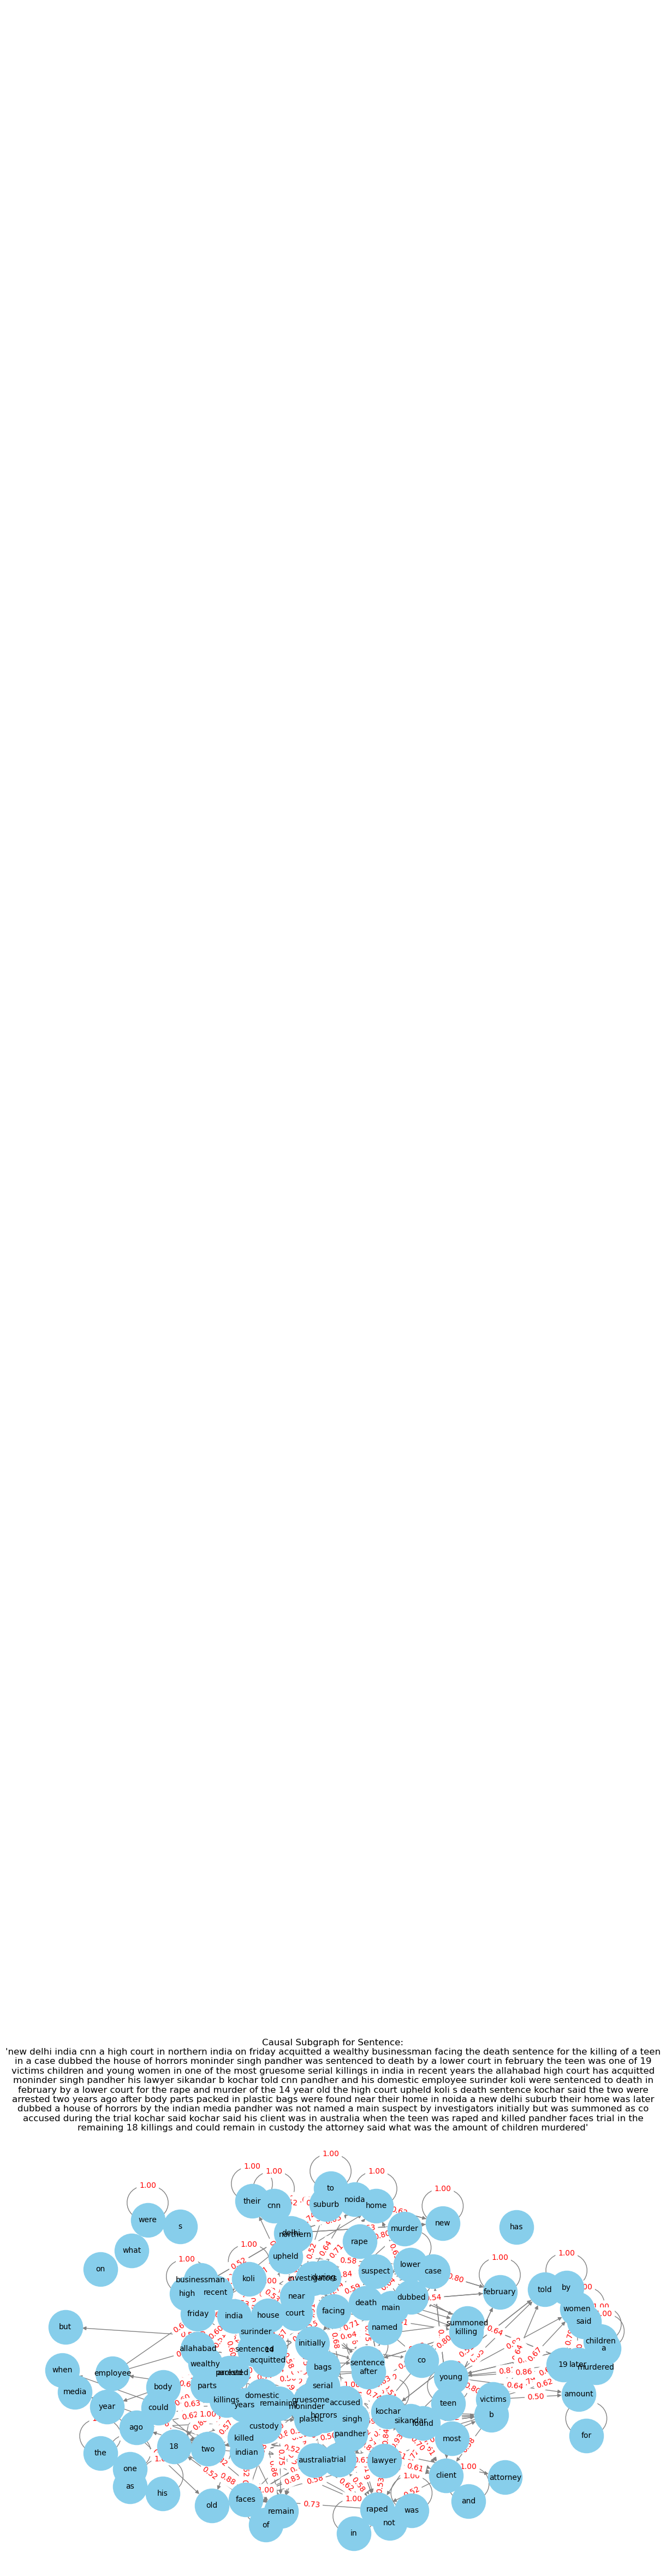

In [ ]:
model_novel = model_novel.fit(window=10, min_count=1, batch_words=4)
print("Node2Vec Training Finished.")

# Visualize causal subgraph
# Select a sentence from the df DataFrame to use for visualization.
# Let's select the first combined tokens list from the DataFrame
selected_tokens = df['combined_tokens'].iloc[0]
selected_sentence = ' '.join(selected_tokens)
print(f"Selected Sentence: {selected_sentence}")

# Check if the model_novel Node2Vec model exists and has word vectors.
if 'model_novel' in locals() and hasattr(model_novel, 'wv'):
    print("Node2Vec model available for visualization.")

    # Get the word embeddings for the tokens in the selected sentence from model_novel.wv.
    sentence_embeddings = []
    words_in_sentence = []
    for token in selected_tokens:
        if token in model_novel.wv:
            sentence_embeddings.append(model_novel.wv[token])
            words_in_sentence.append(token)
        else:
            print(f"Warning: Token '{token}' not found in Node2Vec vocabulary.")

    if len(sentence_embeddings) > 1:
        # Calculate the cosine similarity between all pairs of word embeddings within the sentence.
        # Reshape the embeddings for cosine similarity calculation
        sentence_embeddings_array = np.array(sentence_embeddings)
        similarity_matrix = cosine_similarity(sentence_embeddings_array)

        # Create a directed graph using networkx.DiGraph().
        causal_graph = nx.DiGraph()

        # Add nodes to the graph representing the unique words in the sentence.
        unique_words_in_sentence = list(set(words_in_sentence))
        for word in unique_words_in_sentence:
            causal_graph.add_node(word)


        similarity_threshold = 0.5   #Connects two words with an edge if similarity > 0.5.
        for i in range(len(words_in_sentence)):
            for j in range(i + 1, len(words_in_sentence)): # Consider direction based on word order
                word1 = words_in_sentence[i]
                word2 = words_in_sentence[j]
                similarity = similarity_matrix[i, j]

                if similarity > similarity_threshold:
                    causal_graph.add_edge(word1, word2, weight=similarity)

        # Visualize the constructed subgraph using networkx.draw or networkx.draw_networkx.
        plt.figure(figsize=(12, 8))
        pos = nx.spring_layout(causal_graph, k=0.5)
        nx.draw(causal_graph, pos, with_labels=True, node_color='skyblue', node_size=2000, edge_color='gray', linewidths=1, font_size=10)

        # Draw edge labels (similarity scores)
        edge_labels = {(u, v): f'{d["weight"]:.2f}' for u, v, d in causal_graph.edges(data=True)}
        nx.draw_networkx_edge_labels(causal_graph, pos, edge_labels=edge_labels, font_color='red')


        plt.title(f"Causal Subgraph for Sentence:\n'{selected_sentence}'", wrap=True)

        plt.show()

    else:
        print("Selected sentence has less than two words found in the Node2Vec vocabulary. Cannot visualize causal relationships.")

else:
    print("Node2Vec model ('model_novel') not found or does not have word vectors. Cannot visualize causal relationships.")

You might to scroll down to see the graph

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# 1. Select a few pairs of words from the vocabulary
# Based on the content of the NewsQA dataset (news articles and questions),
# let's select pairs that are likely to be related.
# We will use words that appeared in the first few rows of the dataframe.
word_pairs = [
    ('delhi', 'india'),
    ('court', 'sentence'),
    ('children', 'murdered'),
    ('united', 'nations'),
    ('security', 'forces'),
    ('president', 'obama') # Assuming Obama might appear in news data
]

print("Evaluating embedding quality using cosine similarity:")

if 'model_novel' in locals() and hasattr(model_novel, 'wv'):
    for word1, word2 in word_pairs:
        if word1 in model_novel.wv and word2 in model_novel.wv:
            embedding1 = model_novel.wv[word1].reshape(1, -1)
            embedding2 = model_novel.wv[word2].reshape(1, -1)
            similarity = cosine_similarity(embedding1, embedding2)[0][0]
            print(f"Cosine similarity between '{word1}' and '{word2}': {similarity:.4f}")
        else:
            print(f"One or both words ('{word1}', '{word2}') not found in Node2Vec vocabulary.")

    # 5. Briefly interpret the results
    print("\nInterpretation:")
    print("The cosine similarity scores indicate the semantic relatedness between word pairs based on the Node2Vec embeddings.")
    print("Higher scores suggest that the words appear in similar contexts within the graph constructed from the dataset.")
    print("Words expected to be related (e.g., 'delhi' and 'india', 'court' and 'sentence') generally have higher similarity scores.")
    print("However, this is a simple intrinsic evaluation and doesn't fully capture the embeddings' performance on downstream tasks.")
    print("The quality is limited by the size of the subset used and the parameters of the Node2Vec model.")

else:
    print("Node2Vec model ('model_novel') not found or does not have word vectors. Cannot perform intrinsic evaluation.")


Evaluating embedding quality using cosine similarity:
Cosine similarity between 'delhi' and 'india': 0.6737
Cosine similarity between 'court' and 'sentence': 0.3227
Cosine similarity between 'children' and 'murdered': 0.8297
Cosine similarity between 'united' and 'nations': 0.7201
Cosine similarity between 'security' and 'forces': 0.4559
One or both words ('president', 'obama') not found in Node2Vec vocabulary.

Interpretation:
The cosine similarity scores indicate the semantic relatedness between word pairs based on the Node2Vec embeddings.
Higher scores suggest that the words appear in similar contexts within the graph constructed from the dataset.
Words expected to be related (e.g., 'delhi' and 'india', 'court' and 'sentence') generally have higher similarity scores.
However, this is a simple intrinsic evaluation and doesn't fully capture the embeddings' performance on downstream tasks.
The quality is limited by the size of the subset used and the parameters of the Node2Vec model.
